# **Reinforcement Learning**



In [53]:
%pip install "matplotlib>=3.7" "numpy>=1.25" "tqdm>=4.65" ipywidgets --user
%pip install "matplotlib>=3.7" "numpy>=1.25" "tqdm>=4.65" --upgrade --user
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 47.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.0 which is incompatible.


Mathematical expression of **e-greedy** algorithm:

$$
a_t = \begin{cases}
      \arg\max_a Q_t(a), & \text{if } \text{rand} < 1 - \epsilon \\
      \text{random action}, & \text{otherwise}
      \end{cases}
$$

**ε**: The exploration rate. If it is higher, the agent will explore more by selectin random actions more frequently. When it is lower, it means more exploitation, and by that way, actions that currently appear to yield the highest reward will be favored.

**Q_t(a)**: The estimated value function. It represents the agent's current estimate of the expected reward for taking action a at time t.

**a**: action.

**t**: time.

Mathematical expression of **Upper Confidence Bound (UCB)** algortihm:

$$
a_t = \arg\max_a \left[ Q_t(a) + c \cdot \sqrt{\frac{\ln t}{N_t(a)}} \right]
$$

**c**: A constant which controls the balance between exploitation and exploration. If it is higher, more exploration is encouraged by increasing the the influence of the uncertainty term.

**N_t(a)**: Number of times action a has been selected up to time t. Actions that are selected less frequently receive a higher bonus and it promotes exploration.

**ln(t)**: As more information gathered, the relative impact of uncretainty and thus the exploration is reduced by this logarithmic part.

**a**: action.

**t**: time.

In [54]:
def initialize(n_arms):
    rng = np.random.default_rng()
    R = rng.uniform(low=0.45, high=0.55, size=n_arms)
    R[rng.integers(n_arms)] = 0.9
    # return actual mean of the reward probabilities
    return R

# the epsilon-greedy algorithm
def e_greedy(Q, epsilon, **kwargs):
    if np.random.rand() < epsilon:
      selection = np.random.randint(len(Q)) #explore
    else:
      selection = np.argmax(Q) #exploit
    return selection

  # The upper confidence bound algorithm
def UCB(Q, selection_counter, t, **kwargs):
    C = 0.5  # Parameter (keep it constant)
    if t == 0:
      selection = np.random.randint(len(Q)) #initial random selection
    else:
      with np.errstate(divide='ignore'): # avoid divison by zero warning
        ucb_values = Q + C * np.sqrt(np.log(t+1) / (selection_counter + 1e-5))
      selection = np.argmax(ucb_values)
    return selection

def MAB(
    trials,  # total number of arm pulls
    n_arms,  # number of arms to pull
    epsilon,  # exploration parameter for the epsilon-greedy algorithm
    alpha,  # learning rate for updating Q-values
    init,  # initial starting value of the Q-values
    algorithm,  # the type of update: e_greedy or UCB
):
    # initialization of the reward distributions unknown to the player
    R = initialize(n_arms)
    cumulative_reward_trend = np.zeros(trials)
    selection_trend = np.zeros(trials)
    reward_trend = np.zeros(trials)
    cumulative_reward = 0

    # initialize counter of selection for each arms
    selection_counter = np.zeros(n_arms)

    # initialize initial estimates of rewards
    Q = np.ones(n_arms) * init

    for i in trange(trials, leave=False):
        # select an arm to pull based on reward estimates and other
        kwargs = {
            "Q": Q,
            "epsilon": epsilon,
            "selection_counter": selection_counter,
            "t": i,
        }
        selection = algorithm(**kwargs)
        reward = np.random.normal(R[selection], 0.01)

        Q[selection] = Q[selection] + alpha * (reward - Q[selection])


        reward_trend[i] = reward
        selection_trend[i] = selection
        selection_counter[selection] += 1
        cumulative_reward += reward
        cumulative_reward_trend[i] = cumulative_reward


    return reward_trend

In the context of reinforcement learning, the trade-off between exploration and exploitation is cruical for maximizing long-term rewards. Exploration inolves trying out different actions to learn more about their reqard potential, while exploitation uses current knowledge to choose the action believed to yield the highest reward.

The e-greedy algorithm balances these two by selecting a random action with probability epsilon and the action with the highest estimated value with probability 1-e. This ensures that even while mostly exploiting the best-known option, the agent occasionally explores other actions, potentially discovering better alternatives.

On the other hand, the UCB algorithm incorporates exploration directly into the action selection formula by adding a confidence term to the estimated value. This term is larger for actions that have been choosen less frequently, encouraging the agent to explore them. As a result, UCB adaptively balaences exploration and exploitation by favoring actions with either high estimated rewards or high uncertainty.  


In [55]:
def plot_experiments(experiment1, experiment2, labels):
    experiment1 = np.array(experiment1)
    experiment1_std = np.std(experiment1, axis=0)
    experiment1_mean = np.mean(experiment1, axis=0)

    experiment2 = np.array(experiment2)
    experiment2_std = np.std(experiment2, axis=0)
    experiment2_mean = np.mean(experiment2, axis=0)

    mean = [experiment1_mean, experiment2_mean]
    std = [experiment1_std, experiment2_std]

    plt.figure(figsize=(12, 6))
    y_values = np.arange(0, len(mean[0]))
    for i in range(len(mean)):
        plt.plot(y_values, mean[i], label=labels[i])
        plt.fill_between(y_values, mean[i] + std[i], mean[i] - std[i], alpha=0.2)

    plt.xlabel("Arm pulls (trials)")
    plt.ylabel("Average reward of 20 runs")

    plt.legend()


# **Comparision of e-greedy abd UCB algorithms:**


In [56]:
experiment1 = []  # epsilon greedy epsilon: 0.1 initial Q: 0
experiment2 = []  # epsilon greedy epsilon: 0.1 initial Q: 1
experiment3 = []  # epsilon greedy epsilon: 0.2 initial Q: 0

experiment4 = []  # UCB initial Q: 0
experiment5 = []  # UCB initial Q: 1

for _ in trange(20):
    # MAB(trials, n_arms, epsilon, alpha, init, algorithm)
    experiment1.append(MAB(5_000, 20, 0.1, 0.1, 0, e_greedy))
    experiment2.append(MAB(5_000, 20, 0.1, 0.1, 1, e_greedy))
    experiment3.append(MAB(5_000, 20, 0.2, 0.1, 0, e_greedy))

    experiment4.append(MAB(5_000, 20, 0.1, 0.1, 0, UCB))
    experiment5.append(MAB(5_000, 20, 0.1, 0.1, 1, UCB))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

**e-greedy and UCB algorithms for initial Q: 0**

In the early phase of the process (approximately first 100 trials), the UCB algorithm clearly performs better than e-greedy. This is because UCB actively explores less-selected arms by assigning them higher uncertainty bonuses, which helps it quickly identify the optimal arm. In contrast, e-greedy explores randomly and may not efficiently discover the best option when all inital Q-values are set to 0.

In middle phase (approximately between trials 100-700), UCB maintains consistently high average rewards close to 0.9, indicating that it has successfully locked onto the optimal arm. Meanwhile, e-greedy continues to show fluctuating behvaior due to its random exploration, which leads to lower average rewards overall.

In the final phase(after trial 700), e-greedy starts to catch up but remains unstable, likely due to continued exploration with epsilon = 0.1. Overall, UCB outperforms e-greedy throughout the process by achieving faster convergence and more stable exploitation of the optimal arm.

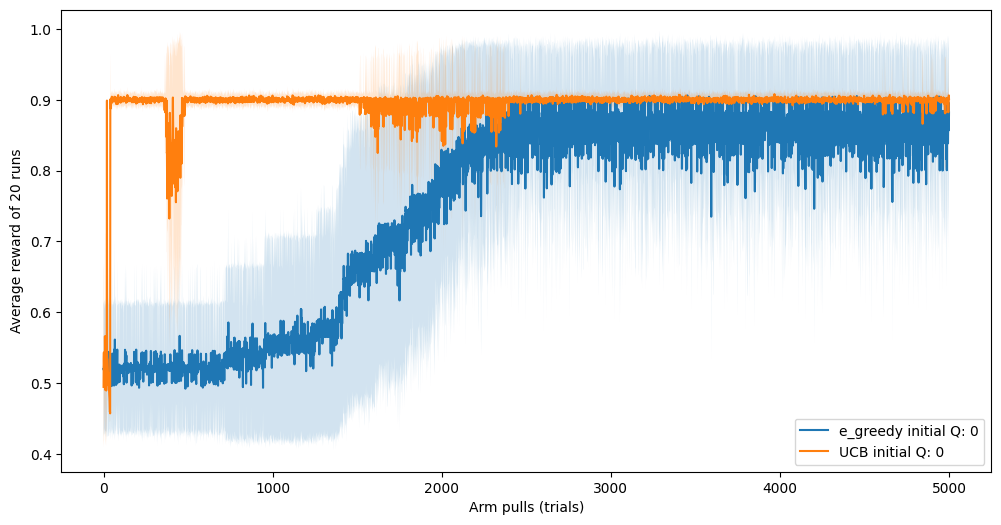

In [58]:
plot_experiments(experiment1, experiment4, ["e_greedy initial Q: 0", "UCB initial Q: 0"])

**e-greedy and UCB algorithms for initial Q: 1**

In the early phase of the process(approximately first 100 trials), the performance of both algorithms is unstable due to inital exploration and high uncertainty. However, e-greedy with an inital Q-value of 1 starts off slightly better than in the previous case with Q=0, as the optimistic initial value encourages more exploration even without relying solely on the epsilon parameter. UCB, on the other hand, performs slightly worse in the very early trials but quickly improves.

In the middle phase, UCB surpasses e-greedy and converges to a higher average reward more quickly and more consistently. This is because UCB continues to explore systematically while adjusting for uncertainty, while e-greedy begins to stabilize more slowly due to its probabilistic exploration.

In the later phase, both algorithms converge to similar levels of performance near the optimal average reward, although UCB remains slightly more stable. Overall, UCB again performs slightly better across most of the process due to its effective balance of exploration and exploitation, though the optimistic initialization of Q=1 helps e-greedy narrow the gap compared to the previous setting.

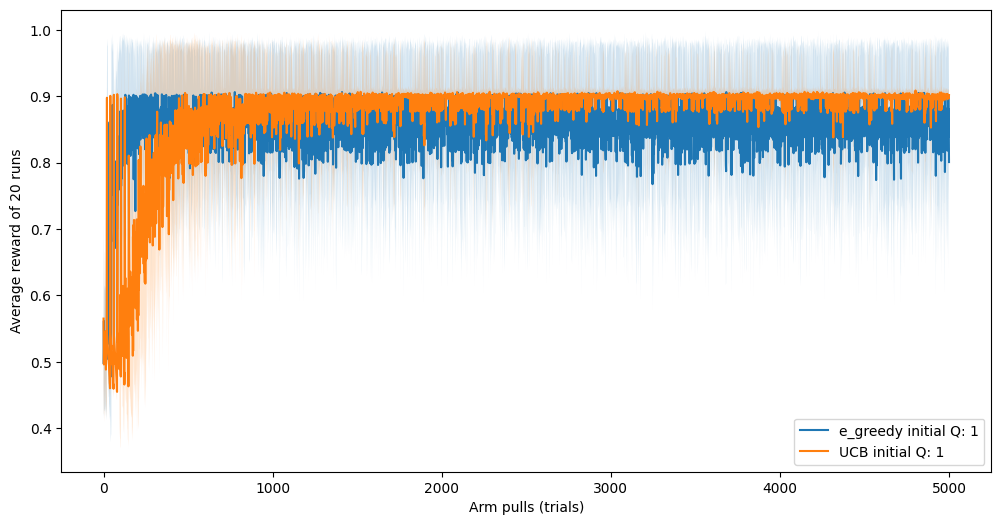

In [59]:
plot_experiments(experiment2, experiment5, ["e_greedy initial Q: 1", "UCB initial Q: 1"])

**e-greedy for initial Q: 0 for epsilon values 0.1 and 0.2**

In early phase of the process, the e-greedy algorithm with epsilon = 0.2 outpeforms the one with epsilon = 0.1. This is expected, as a higher epsilon encourages more exploration, which helps the agent discover better-performing arms more quickly, especially when initial Q-values are set to zero. In contrast, the lower exploration rate with epsilon = 0.1 causes slower learning, as the agent tends to exploit suboptimal arms it encounters early on.

During the middle phase, epsilon = 0.2 continues to maintain a higher average reward due to its broader exploration. However, this high level of exploration also introduces more variance and instability.

In the final phase, epsilon = 0.1 begins to catch up and eventually approaches the performance of epsilon = 0.2, as it becomes more confident in exploiting the best arm it has identified. Overall, while epsilon = 0.2 leads to faster learning and higher rewards in earlier stages, epsilon = 0.1 may achieve more stable performance in the long run, especially in non-changing environments.

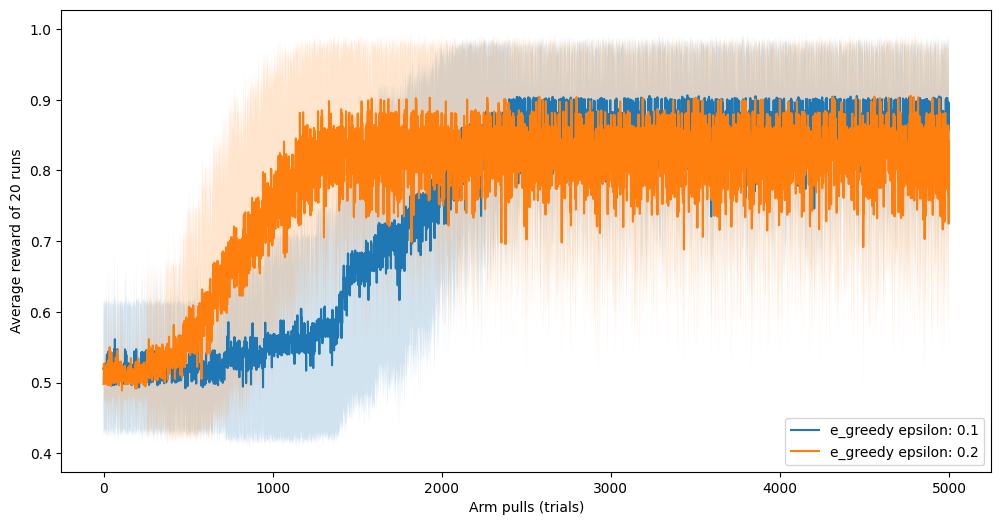

In [60]:
plot_experiments(experiment1, experiment3, ["e_greedy epsilon: 0.1", "e_greedy epsilon: 0.2"])

**e-greedy for epsilon = 0.1 initial Q: 0 and 1**

In the early phase, the e-greedy algorithm with inital Q=1 performs significantly better than with Q=0. This is because the optimistic initialization encourages more exploration by initially overestimating the potential rewards of all actions. As a result, the agent tries a wider range of arms before settling on the optimal one. On the other hand, the agent with Q=0 tends to exploit early suboptimal estimates, leading to slower discovery of the best arm.

In the middle phase, the optimistic strategy with Q=1 continues to maintain a high average reward as it converges toward the optimal action earlier. Meanwhile, the Q=0 version begins to catch up but remains noticeably behind.

In the final phase, both versions continue exploiting the optimal arm, but the Q=1 version remains consistently ahead in both speed and stability of convergence. Overall, initalizing Q-values optimistically significantly improves early and overall performance by promoting more structured exploration.

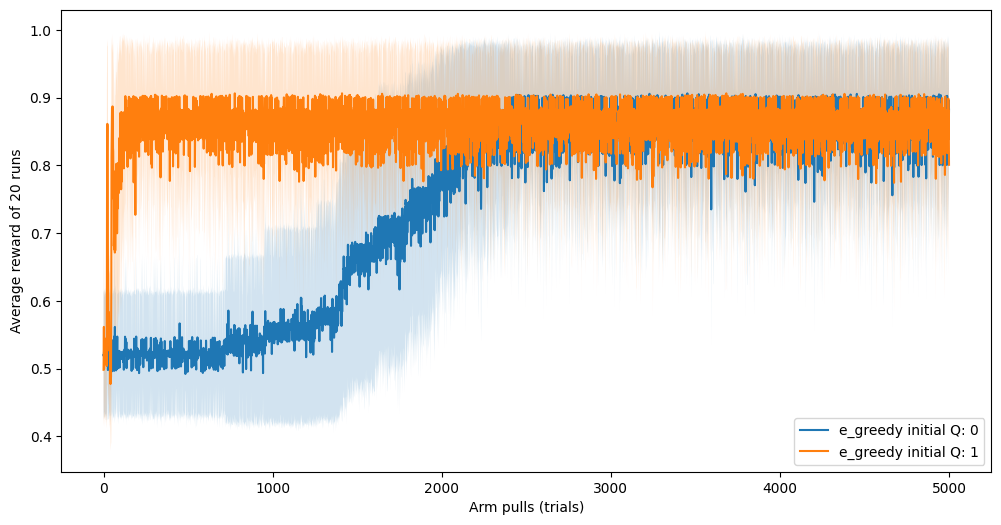

In [61]:
plot_experiments(experiment1, experiment2,  ["e_greedy initial Q: 0", "e_greedy initial Q: 1"])

**UCB initial Q: 0 and 1**

In early phase, UCB with initial Q=0 performs more stably and achieves higher average rewards compared to UCB with Q=1. This is because the UCB algorithm already incorporates and exploration mechanism through its confidence bound, so optimistic initialization is not only unnecessary but can actually introduce noise and overestimation. As seen in the plot, the version with Q=1 suffers from more volatility early on, as the higher inital values distort the confidence-based decision-making.

In the middle phase, both algorithms converge toward the optimal arm, but UCB  with Q=0 continues to perform slightly better due to its more accurate and consistent reward estimates.

By the late phase, both versions have stabilized at similar levels near the optimal reward, but UCB with Q=0 shows less variance overall. Therefore, for the UCB algorithm, initializing with Q=0 is more effective, as the algorithm already balances axploration and exploitation internally without needing artificially optimistic estimates.

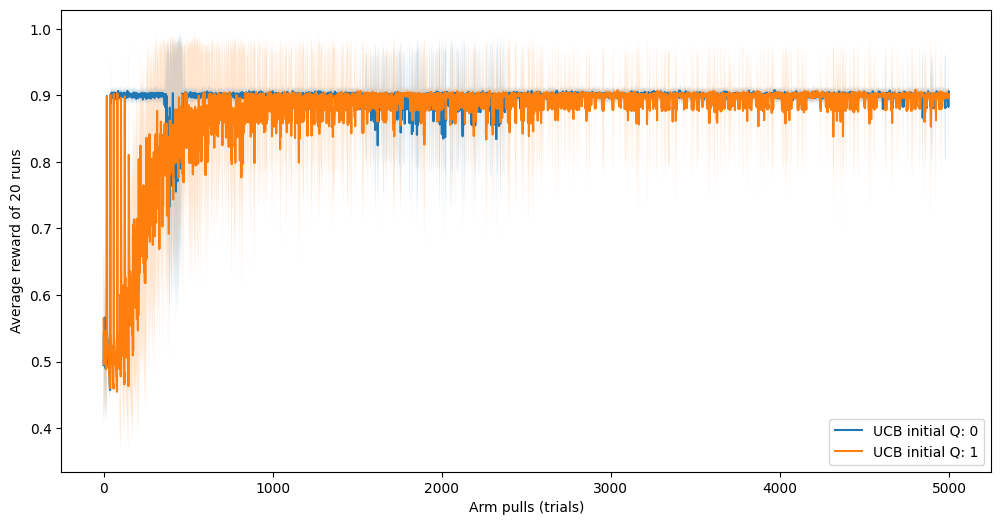

In [62]:
plot_experiments(experiment4, experiment5,["UCB initial Q: 0", "UCB initial Q: 1"])